<a href="https://colab.research.google.com/github/kursatkara/MAE_5020_Spring_2025/blob/master/08_02_PINN_SHM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-Informed Neural Network (PINN): Damped Simple Harmonic Oscillator

In this example, we apply a **Physics-Informed Neural Network (PINN)** to solve the damped simple harmonic oscillator equation. Such systems frequently appear in aerospace engineering contexts, including vibration analysis and structural dynamics.

## Governing Equation

Consider a damped harmonic oscillator defined by:

$$
\frac{d^2 y}{dt^2} + 2\zeta \omega \frac{dy}{dt} + \omega^2 y = 0
$$

with initial conditions:

$$
y(0) = y_0, \quad \frac{dy}{dt}(0) = v_0
$$

where:

- \\(\zeta\\) is the damping ratio.
- \\(\omega\\) is the natural frequency.
- \\(y_0\\) and \\(v_0\\) are initial displacement and velocity, respectively.

## Analytical Solution

The analytical solution for the underdamped case \\((\zeta < 1)\\) is:

$$
y(t) = e^{-\zeta\omega t}\left[y_0\cos(\omega_d t) + \frac{v_0 + \zeta\omega y_0}{\omega_d}\sin(\omega_d t)\right]
$$

where:

- \\(\omega_d = \omega\sqrt{1-\zeta^2}\\) is the damped natural frequency.

## Objective

Use a PINN to approximate the solution by training a neural network that minimizes:

- The physics-informed residual (satisfying the differential equation).
- Initial condition constraints.

This demonstrates how PINNs integrate physics directly into neural network training, yielding physically consistent solutions without explicit numerical discretization.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)


In [ ]:
# Parameters
zeta = 0.1          # Damping ratio
omega = 2.0         # Natural frequency (rad/s)
y0, v0 = 1.0, 0.0   # Initial displacement and velocity

omega_d = omega * np.sqrt(1 - zeta**2)

# Analytical solution
def analytical_solution(t):
    return np.exp(-zeta*omega*t)*(y0*np.cos(omega_d*t) +
           ((v0 + zeta*omega*y0)/omega_d)*np.sin(omega_d*t))


In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, t):
        return self.model(t)


In [ ]:
def pinn_loss(model, t_colloc, t_ic, y_ic, dy_ic):
    t_colloc.requires_grad = True
    y_pred = model(t_colloc)

    # First derivative dy/dt
    dy_dt = torch.autograd.grad(y_pred, t_colloc,
                                grad_outputs=torch.ones_like(y_pred),
                                create_graph=True)[0]

    # Second derivative d²y/dt²
    d2y_dt2 = torch.autograd.grad(dy_dt, t_colloc,
                                  grad_outputs=torch.ones_like(dy_dt),
                                  create_graph=True)[0]

    # ODE residual
    res = d2y_dt2 + 2*zeta*omega*dy_dt + omega**2 * y_pred
    loss_res = torch.mean(res**2)

    # Initial conditions
    y_ic_pred = model(t_ic[0:1])
    dy_ic_pred = torch.autograd.grad(model(t_ic[1:2]), t_ic[1:2],
                                     grad_outputs=torch.ones_like(t_ic[1:2]),
                                     create_graph=True)[0]

    loss_ic = (y_ic_pred - y_ic)**2 + (dy_ic_pred - dy_ic)**2

    return loss_res + loss_ic


In [ ]:
# Time domain and collocation points
t_colloc = torch.linspace(0, 5, 100).unsqueeze(-1)

# Initial condition points (displacement at t=0, velocity at t=0)
t_ic_y = torch.tensor([[0.0]], requires_grad=True)  # For y(0)
t_ic_dy = torch.tensor([[0.0]], requires_grad=True)  # For dy/dt at t=0

y_ic = torch.tensor([[y0]])
dy_ic = torch.tensor([[v0]])

# Model and optimizer
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5000
for epoch in range(epochs + 1):
    optimizer.zero_grad()

    # Compute residual loss
    t_colloc.requires_grad = True
    y_pred = model(t_colloc)
    dy_dt = torch.autograd.grad(y_pred, t_colloc, torch.ones_like(y_pred), create_graph=True)[0]
    d2y_dt2 = torch.autograd.grad(dy_dt, t_colloc, torch.ones_like(dy_dt), create_graph=True)[0]

    res = d2y_dt2 + 2*zeta*omega*dy_dt + omega**2*y_pred
    loss_res = torch.mean(res**2)

    # Initial conditions loss
    y_ic_pred = model(t_ic_y)
    dy_ic_pred = torch.autograd.grad(model(t_ic_dy), t_ic_dy, torch.ones_like(t_ic_dy), create_graph=True)[0]

    loss_ic = (y_ic_pred - y_ic)**2 + (dy_ic_pred - dy_ic)**2

    # Total loss
    loss = loss_res + loss_ic
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')



Epoch 0, Loss: 2.125793
Epoch 500, Loss: 0.218605
Epoch 1000, Loss: 0.101992
Epoch 1500, Loss: 0.062689
Epoch 2000, Loss: 0.043997
Epoch 2500, Loss: 0.025663
Epoch 3000, Loss: 0.012683
Epoch 3500, Loss: 0.005812
Epoch 4000, Loss: 0.002567
Epoch 4500, Loss: 0.001168
Epoch 5000, Loss: 0.000441


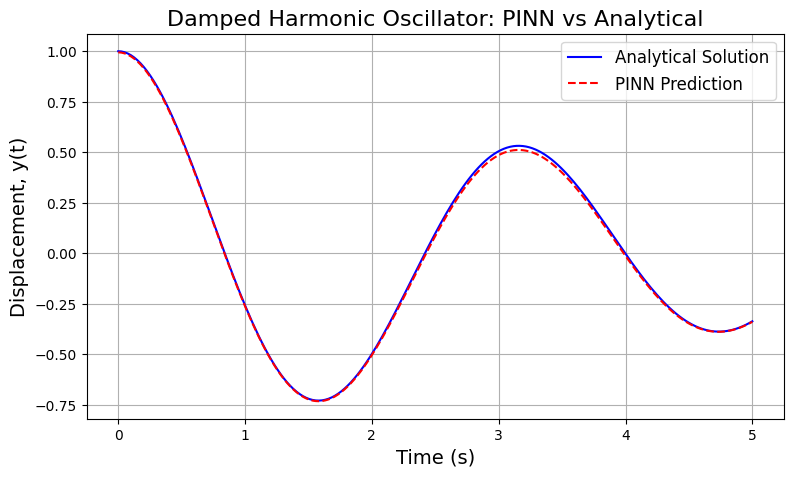

In [ ]:
# Test data
t_test = torch.linspace(0, 5, 200).unsqueeze(-1)
y_pinn = model(t_test).detach().numpy().flatten()
t_test_np = t_test.numpy().flatten()
y_exact = analytical_solution(t_test_np)

# Plotting
plt.figure(figsize=(9,5))
plt.plot(t_test_np, y_exact, 'b-', label='Analytical Solution')
plt.plot(t_test_np, y_pinn, 'r--', label='PINN Prediction')
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Displacement, y(t)', fontsize=14)
plt.title('Damped Harmonic Oscillator: PINN vs Analytical', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


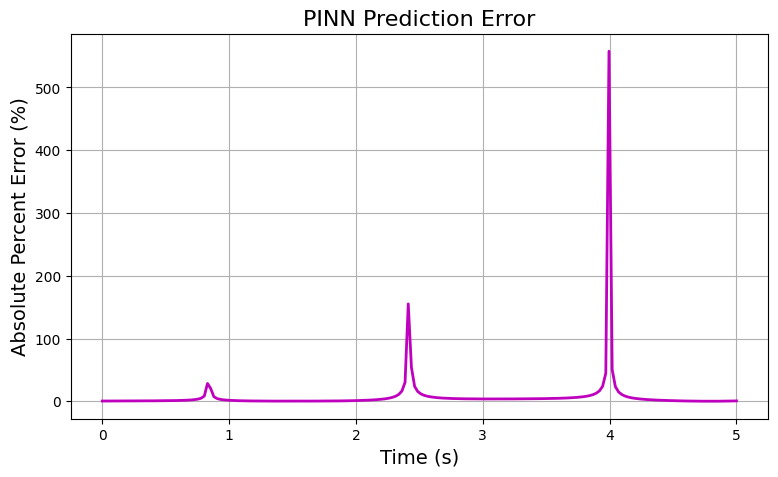

In [ ]:
epsilon = 1e-8  # avoid division by zero
abs_percent_error = np.abs((y_exact - y_pinn) / (y_exact + epsilon)) * 100

plt.figure(figsize=(9,5))
plt.plot(t_test_np, abs_percent_error, 'm-', linewidth=2)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Absolute Percent Error (%)', fontsize=14)
plt.title('PINN Prediction Error', fontsize=16)
plt.grid(True)
plt.show()


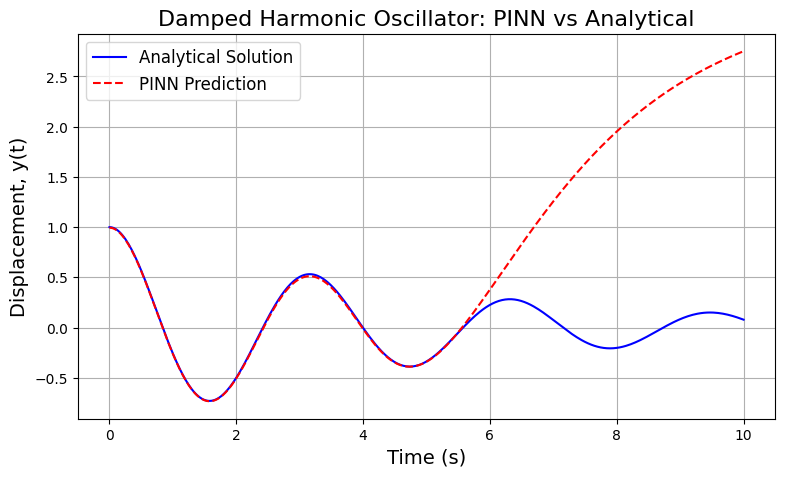

In [ ]:
# Test data for longer times
t_test = torch.linspace(0, 10, 400).unsqueeze(-1)
y_pinn = model(t_test).detach().numpy().flatten()
t_test_np = t_test.numpy().flatten()
y_exact = analytical_solution(t_test_np)

# Plotting
plt.figure(figsize=(9,5))
plt.plot(t_test_np, y_exact, 'b-', label='Analytical Solution')
plt.plot(t_test_np, y_pinn, 'r--', label='PINN Prediction')
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Displacement, y(t)', fontsize=14)
plt.title('Damped Harmonic Oscillator: PINN vs Analytical', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

PINNs sometimes struggle to predict future times (extrapolation beyond training intervals) due to several fundamental reasons:

1. **Limited Physics Enforcement Domain**
PINNs enforce physics primarily at collocation points within the training interval. Outside this interval, the model sees no physics constraints, causing predictions to drift.

2. **Neural Network Generalization**
Neural networks inherently interpolate well but extrapolate poorly. Without explicit training or boundary constraints beyond the training window, PINNs can produce non-physical results.

3. **Error Accumulation**
Even small errors within the training domain can amplify significantly outside this region, especially for dynamic systems.

4. **Complexity and Stiffness of Equations**
Highly nonlinear or stiff equations are particularly challenging to extrapolate without additional constraints or adaptive sampling.

**How to Improve PINN Extrapolation** (Predicting Future Times):

* Extend the Training Domain:
Include collocation points beyond the original interval to guide the network explicitly for future predictions.

* Adaptive Sampling and Refinement:
Dynamically sample more points in challenging regions (such as near boundaries or extrapolation regions).

* Physics-based Constraints:
Embed physical boundary or asymptotic behaviors explicitly into the PINN loss.

* Time Integration Strategies:
Consider step-wise or sequential training, moving forward incrementally in time (similar to traditional time-integration methods).

* Increased Network Capacity and Regularization:
Deeper or wider neural networks combined with regularization (such as weight decay or dropout) can generalize better.

## Key Idea for Embedding Physics-Based Constraints

To significantly enhance the ability of Physics-Informed Neural Networks (PINNs) to accurately predict future states (extrapolation), explicitly embed known physical constraints into the loss function. For the damped harmonic oscillator, such physics-based constraints include:

- **Long-term behavior**:  
  As $t \rightarrow \infty$, the displacement must decay exponentially to zero due to damping:
  $$
  y(t) \rightarrow 0
  $$
- **Decay rate enforcement**:  
  The displacement must decay at a known rate given by the damping factor:
  $$
  y(t) \sim e^{-\zeta \omega t}
  $$

Including these explicit constraints within the PINN loss function ensures the neural network solutions inherently satisfy both short-term accuracy and long-term physical consistency.


In [ ]:
def enhanced_pinn_loss(model, t_colloc, t_ic_y, t_ic_dy, y_ic, dy_ic, zeta, omega):
    # Standard PINN loss components
    t_colloc.requires_grad = True
    y_pred = model(t_colloc)

    dy_dt = torch.autograd.grad(y_pred, t_colloc,
                                grad_outputs=torch.ones_like(y_pred),
                                create_graph=True)[0]

    d2y_dt2 = torch.autograd.grad(dy_dt, t_colloc,
                                  grad_outputs=torch.ones_like(dy_dt),
                                  create_graph=True)[0]

    # Residual of the ODE
    res = d2y_dt2 + 2*zeta*omega*dy_dt + omega**2*y_pred
    loss_res = torch.mean(res**2)

    # Initial conditions constraints
    y_ic_pred = model(t_ic_y)
    dy_ic_pred = torch.autograd.grad(model(t_ic_dy), t_ic_dy,
                                     grad_outputs=torch.ones_like(t_ic_dy),
                                     create_graph=True)[0]

    loss_ic = (y_ic_pred - y_ic)**2 + (dy_ic_pred - dy_ic)**2

    # Additional Physics-based constraint (long-term decay)
    t_future = torch.linspace(5, 10, 50).unsqueeze(-1)
    y_future_pred = model(t_future)

    # We know physically y(t) → 0 as t → ∞, enforce explicitly:
    loss_future_decay = torch.mean(y_future_pred**2)

    # Total loss with weighting
    loss = loss_res + loss_ic + 0.1 * loss_future_decay
    return loss


In [ ]:
# Define points for initial conditions explicitly
t_ic_y = torch.tensor([[0.0]], requires_grad=True)
t_ic_dy = torch.tensor([[0.0]], requires_grad=True)
y_ic = torch.tensor([[y0]])
dy_ic = torch.tensor([[v0]])

# Collocation points now slightly extended to embed physics
t_colloc = torch.linspace(0, 5, 100).unsqueeze(-1)

# Model and optimizer
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5000
for epoch in range(epochs+1):
    optimizer.zero_grad()
    loss = enhanced_pinn_loss(model, t_colloc, t_ic_y, t_ic_dy, y_ic, dy_ic, zeta, omega)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')


Epoch 0, Loss: 1.369778
Epoch 500, Loss: 0.163341
Epoch 1000, Loss: 0.060178
Epoch 1500, Loss: 0.038982
Epoch 2000, Loss: 0.031982
Epoch 2500, Loss: 0.022040
Epoch 3000, Loss: 0.013986
Epoch 3500, Loss: 0.002681
Epoch 4000, Loss: 0.001220
Epoch 4500, Loss: 0.001067
Epoch 5000, Loss: 0.000996


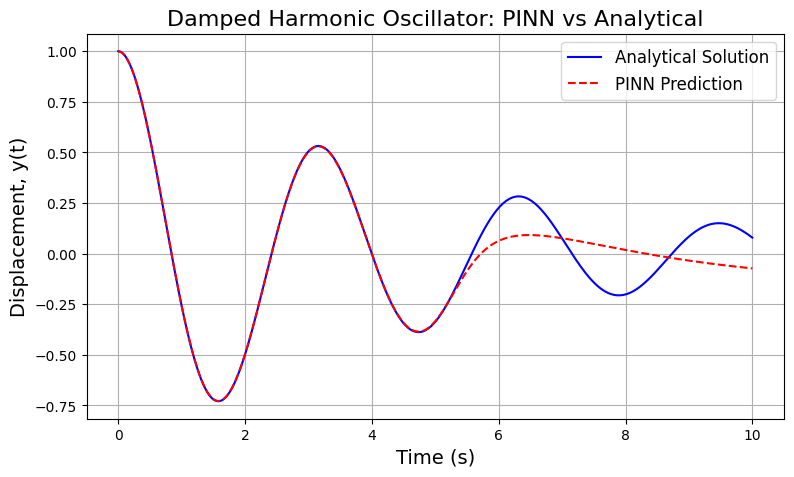

In [ ]:
# Test data for longer times
t_test = torch.linspace(0, 10, 400).unsqueeze(-1)
y_pinn = model(t_test).detach().numpy().flatten()
t_test_np = t_test.numpy().flatten()
y_exact = analytical_solution(t_test_np)

# Plotting
plt.figure(figsize=(9,5))
plt.plot(t_test_np, y_exact, 'b-', label='Analytical Solution')
plt.plot(t_test_np, y_pinn, 'r--', label='PINN Prediction')
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Displacement, y(t)', fontsize=14)
plt.title('Damped Harmonic Oscillator: PINN vs Analytical', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
# Define points for initial conditions explicitly
t_ic_y = torch.tensor([[0.0]], requires_grad=True)
t_ic_dy = torch.tensor([[0.0]], requires_grad=True)
y_ic = torch.tensor([[y0]])
dy_ic = torch.tensor([[v0]])

# Collocation points now slightly extended to embed physics
t_colloc = torch.linspace(0, 5, 100).unsqueeze(-1)

# Model and optimizer
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20000
for epoch in range(epochs+1):
    optimizer.zero_grad()
    loss = enhanced_pinn_loss(model, t_colloc, t_ic_y, t_ic_dy, y_ic, dy_ic, zeta, omega)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')


Epoch 0, Loss: 4.588207
Epoch 500, Loss: 0.258249
Epoch 1000, Loss: 0.115541
Epoch 1500, Loss: 0.088407
Epoch 2000, Loss: 0.053714
Epoch 2500, Loss: 0.037842
Epoch 3000, Loss: 0.023851
Epoch 3500, Loss: 0.003009
Epoch 4000, Loss: 0.001083
Epoch 4500, Loss: 0.001021
Epoch 5000, Loss: 0.000987
Epoch 5500, Loss: 0.000960
Epoch 6000, Loss: 0.001038
Epoch 6500, Loss: 0.000913
Epoch 7000, Loss: 0.000892
Epoch 7500, Loss: 0.001452
Epoch 8000, Loss: 0.000862
Epoch 8500, Loss: 0.000835
Epoch 9000, Loss: 0.000817
Epoch 9500, Loss: 0.000879
Epoch 10000, Loss: 0.000782
Epoch 10500, Loss: 0.000767
Epoch 11000, Loss: 0.000753
Epoch 11500, Loss: 0.000740
Epoch 12000, Loss: 0.000728
Epoch 12500, Loss: 0.000717
Epoch 13000, Loss: 0.000795
Epoch 13500, Loss: 0.000698
Epoch 14000, Loss: 0.000690
Epoch 14500, Loss: 0.000714
Epoch 15000, Loss: 0.001015
Epoch 15500, Loss: 0.000670
Epoch 16000, Loss: 0.000664
Epoch 16500, Loss: 0.000661
Epoch 17000, Loss: 0.002872
Epoch 17500, Loss: 0.000652
Epoch 18000, Los

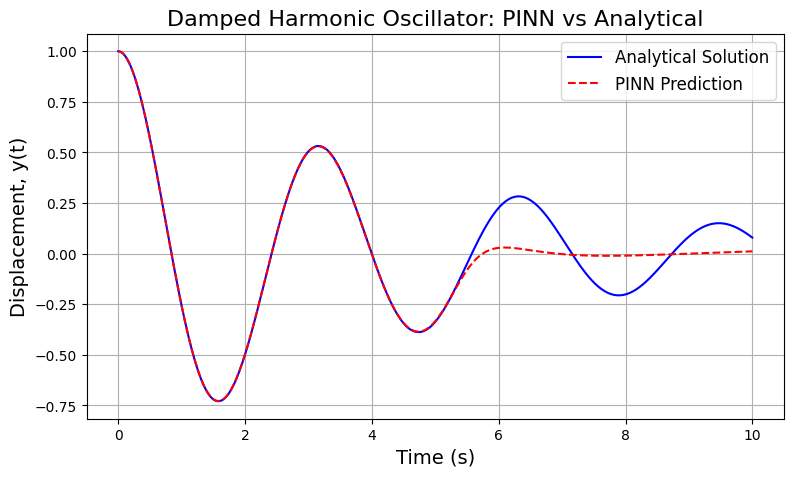

In [ ]:
# Test data for longer times
t_test = torch.linspace(0, 10, 400).unsqueeze(-1)
y_pinn = model(t_test).detach().numpy().flatten()
t_test_np = t_test.numpy().flatten()
y_exact = analytical_solution(t_test_np)

# Plotting
plt.figure(figsize=(9,5))
plt.plot(t_test_np, y_exact, 'b-', label='Analytical Solution')
plt.plot(t_test_np, y_pinn, 'r--', label='PINN Prediction')
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Displacement, y(t)', fontsize=14)
plt.title('Damped Harmonic Oscillator: PINN vs Analytical', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
def enhanced_pinn_loss(model, t_colloc, t_ic_y, t_ic_dy, y_ic, dy_ic, zeta, omega):
    # Standard PINN loss components
    t_colloc.requires_grad = True
    y_pred = model(t_colloc)

    dy_dt = torch.autograd.grad(y_pred, t_colloc,
                                grad_outputs=torch.ones_like(y_pred),
                                create_graph=True)[0]

    d2y_dt2 = torch.autograd.grad(dy_dt, t_colloc,
                                  grad_outputs=torch.ones_like(dy_dt),
                                  create_graph=True)[0]

    # Residual of the ODE
    res = d2y_dt2 + 2*zeta*omega*dy_dt + omega**2*y_pred
    loss_res = torch.mean(res**2)

    # Initial conditions constraints
    y_ic_pred = model(t_ic_y)
    dy_ic_pred = torch.autograd.grad(model(t_ic_dy), t_ic_dy,
                                     grad_outputs=torch.ones_like(t_ic_dy),
                                     create_graph=True)[0]

    loss_ic = (y_ic_pred - y_ic)**2 + (dy_ic_pred - dy_ic)**2

    # Additional Physics-based constraint (long-term decay)
    t_future = torch.linspace(5, 10, 50).unsqueeze(-1)
    y_future_pred = model(t_future)

    # We know physically y(t) → 0 as t → ∞, enforce explicitly:
    loss_future_decay = torch.mean(y_future_pred**2)

    # Total loss with weighting
    loss = loss_res + loss_ic + 0.1 * loss_future_decay
    return loss